Based on https://gitlab.com/andsta/diro2c/-/blob/develop/show_decision_boundaries_gaussians.py

Originally published as https://doi.org/10.5281/zenodo.5362220

Modifications:
- added `probability=True` parameter to SVC instantiation, to enable `predict_proba` and `predict_log_proba` functions of the classifiers
- different train/test split

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import shap
from sklearn import svm
from sklearn.datasets import make_gaussian_quantiles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from clustering import make_clustering

# Make Task

In [2]:
feature_names = np.array(['x1', 'x2'])
feature_precisions = [1, 1]

In [3]:
X, y = make_gaussian_quantiles(n_samples=600,
                               n_classes=2, shuffle=False, cov=0.8, random_state=7)
X = X * 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
clf_a = svm.SVC(random_state=1, probability=True)
clf_a.fit(X_train, y_train)

X2, y2 = make_gaussian_quantiles(n_samples=600,
                                 n_classes=2, shuffle=False, cov=1.3, random_state=7)
X2 = X2 * 100
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=0)
clf_b = svm.SVC(random_state=1, probability=True)
clf_b.fit(X2_train, y2_train)

X_explain = X_test
y_explain = y_test

with open('data/task.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions), f)

In [3]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions = pickle.load(f)

In [5]:
print(classification_report(clf_a.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       150
           1       0.97      1.00      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [6]:
print(classification_report(clf_b.predict(X2_test), y2_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       150
           1       0.97      1.00      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

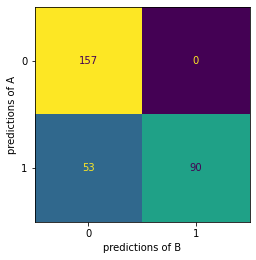

In [8]:
comparer.plot_confusion_matrix(X_train)

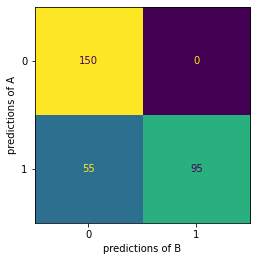

In [9]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('figures/gaussian-cm.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


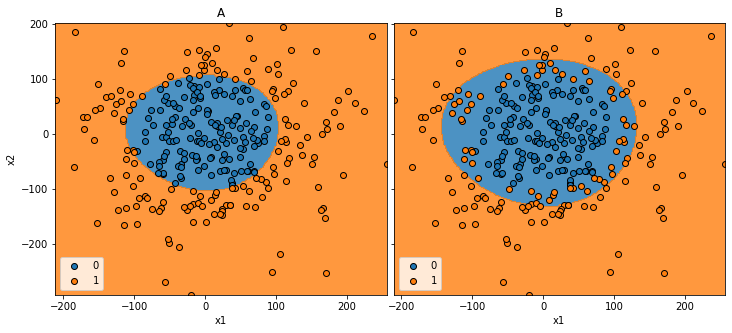

In [10]:
comparer.plot_individual_clf_decision_boundaries(X_explain, y_true=y_explain, kind='label', mesh_step_size=2)
plt.savefig('figures/gaussian-decision-boundaries-indiv.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


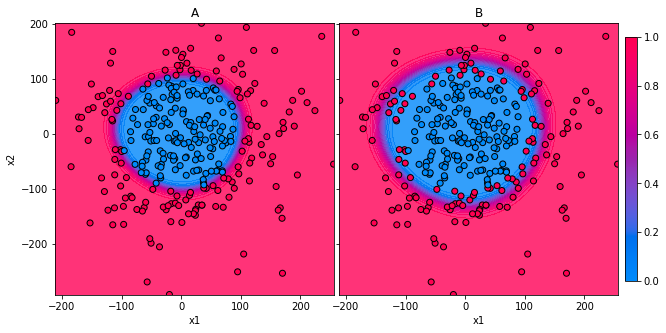

In [11]:
comparer.plot_individual_clf_decision_boundaries(X_explain, y_true=y_explain, kind='proba', mesh_step_size=2)
plt.savefig('figures/gaussian-indiv-proba.pdf', bbox_inches='tight', pad_inches=0)

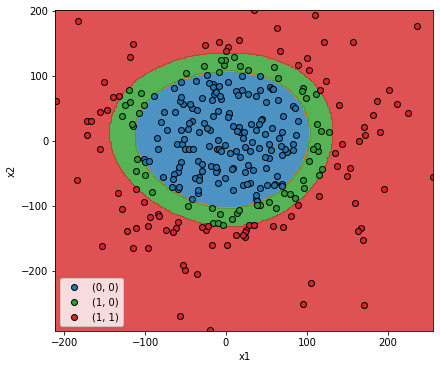

In [12]:
comparer.plot_decision_boundaries(X_explain, mesh_step_size=2)
plt.savefig('figures/gaussian-decision-boundaries-diffclf.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


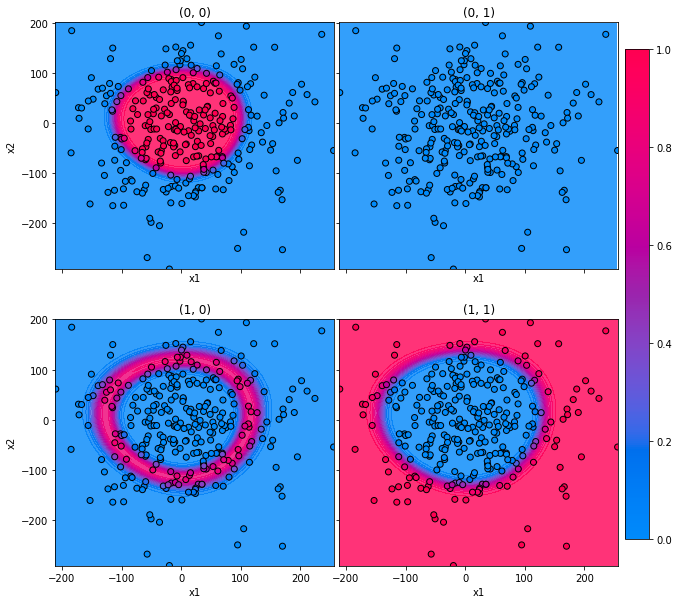

In [13]:
comparer.plot_decision_boundaries(X_explain, kind='proba', mesh_step_size=2)
plt.savefig('figures/gaussian-diffclf-proba.pdf', bbox_inches='tight', pad_inches=0)

# Test Set

In [29]:
X_explain_test, _ = make_blobs(n_samples=10000, centers=1, cluster_std=100, random_state=2)
y_explain_test = comparer.predict_mclass_diff(X_explain_test)
with open('data/test.pickle', 'wb') as f:
    pickle.dump((X_explain_test, y_explain_test), f)

In [14]:
with open('data/test.pickle', 'rb') as f:
    X_explain_test, y_explain_test = pickle.load(f)

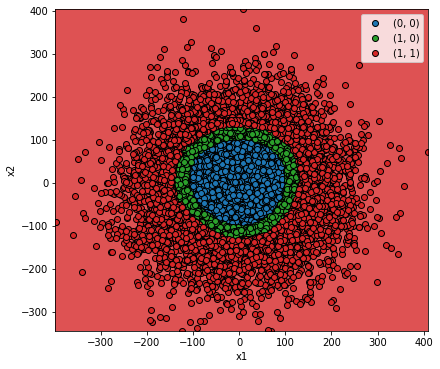

In [15]:
comparer.plot_decision_boundaries(X_explain_test, mesh_step_size=2)
plt.savefig('figures/gaussian-scatter-test.pdf', bbox_inches='tight', pad_inches=0)

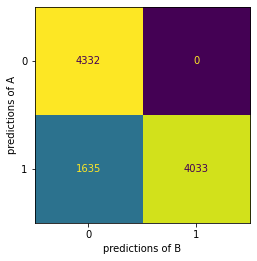

In [16]:
comparer.plot_confusion_matrix(X_explain_test)
plt.savefig('figures/gaussian-cm-test.pdf', bbox_inches='tight', pad_inches=0)

# Comparing Prediction Spaces

In [12]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [13]:
%%time
indiv_shap_values_labels = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
indiv_shap_values_proba = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='proba')
indiv_shap_values_log_odds = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values_labels = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
diffclf_shap_values_proba = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='proba')
diffclf_shap_values_log_odds = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.labels.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_labels, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/indiv.proba.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_proba, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_log_odds, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.labels.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_labels, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.proba.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_proba, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_log_odds, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [01:19,  7.24it/s]                         
Exact explainer: 601it [00:58,  8.38it/s]                         
Exact explainer: 601it [01:01,  8.05it/s]                         
Exact explainer: 601it [00:56,  9.04it/s]                         
Exact explainer: 601it [00:58,  8.41it/s]                         
Exact explainer: 601it [01:00,  8.18it/s]                         


CPU times: user 5min 48s, sys: 3.86 s, total: 5min 52s
Wall time: 6min 14s


# Additional Plots

In [5]:
approaches = ['baseline', 'diro2c', 'shap']
metrics_per_approach = {}
for approach in approaches:
    with open(f'data/fidelity-{approach}.pickle', 'rb') as f:
        metrics_per_approach[approach] = pickle.load(f)

In [6]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [28]:
df = pd.concat(metrics_per_approach, names=['Approach']).reset_index()
df = df[df['Constraints'] <= 100]

In [29]:
hue_order = ['diro2c', 'shap', 'baseline']

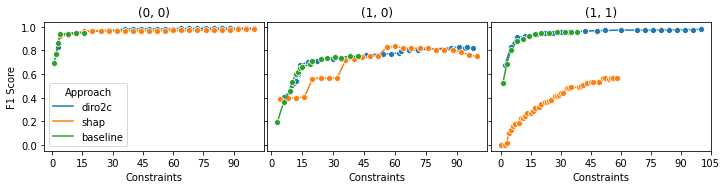

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(3*3.3, 2.5), sharey='all', constrained_layout=True)
for label, ax in zip(np.unique(df['Label']), axs.flat):
    legend = ax == axs[0]
    data = df[df['Label'] == label]
    ax.set_title(label)
    sns.lineplot(data=data, x='Constraints', y='F1 Score', hue='Approach', hue_order=hue_order, marker='o', ax=ax, legend=legend)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.set_constrained_layout_pads(w_pad=0, wspace=0)
plt.savefig('figures/gaussian-fidelity.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
from explainers import plot_feature_dependence
import shap

In [6]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

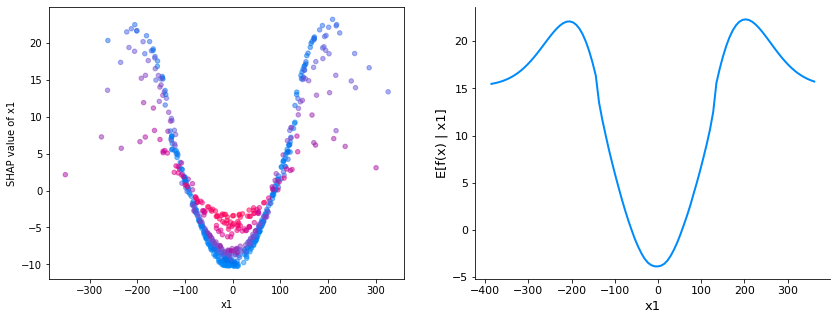

In [7]:
feature_idx, feature_name = comparer.check_feature('x1')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], 'x1', alpha=0.5, show=False, ax=axs[0],
                        color=shap_values[:, 'x2', 'A.1'].values, color_label='x2')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

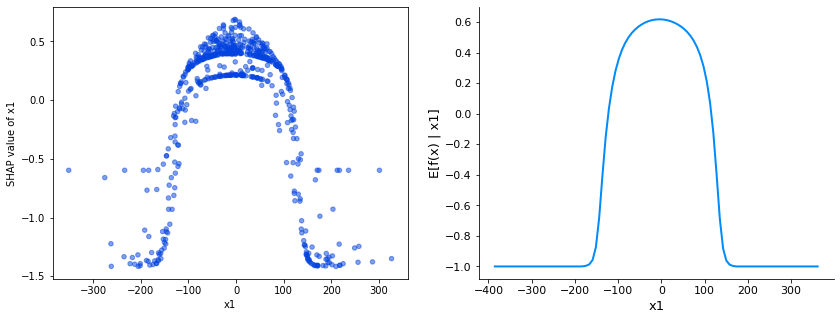

In [9]:
feature_idx, feature_name = comparer.check_feature('x1')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'B.0'], 'x1', alpha=0.5, show=False, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 2],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

# Traditional SHAP Explanations

## Labels

In [14]:
with open('explanations/indiv.labels.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [15]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

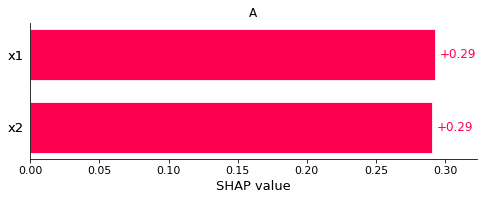

In [16]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

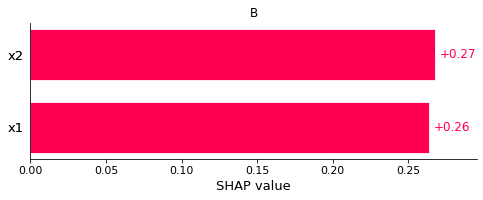

In [17]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

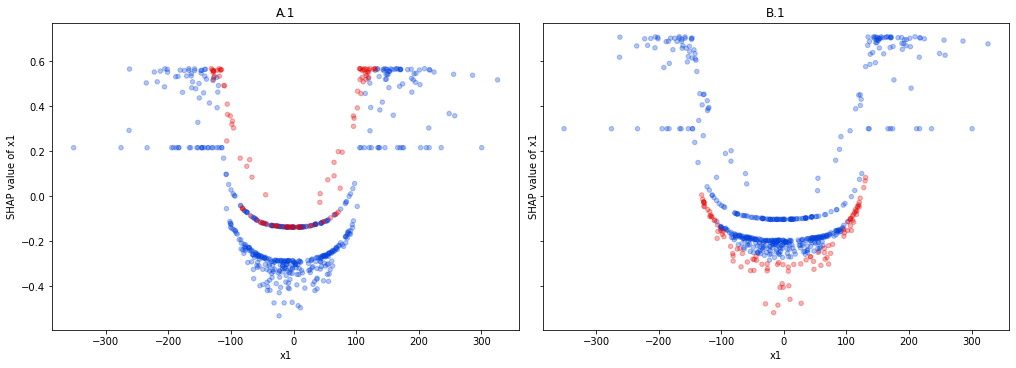

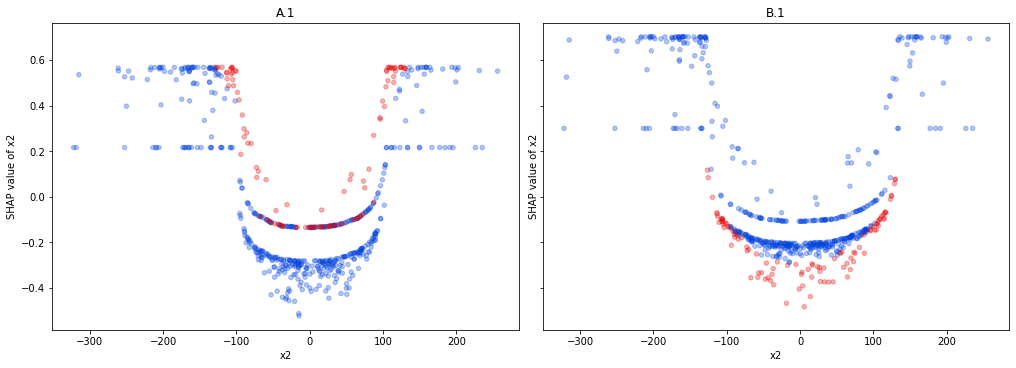

In [18]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Probability

In [19]:
with open('explanations/indiv.proba.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [20]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

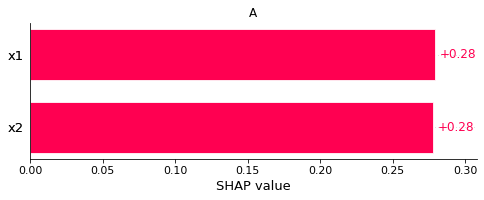

In [21]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

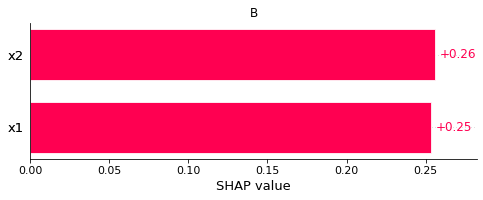

In [22]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

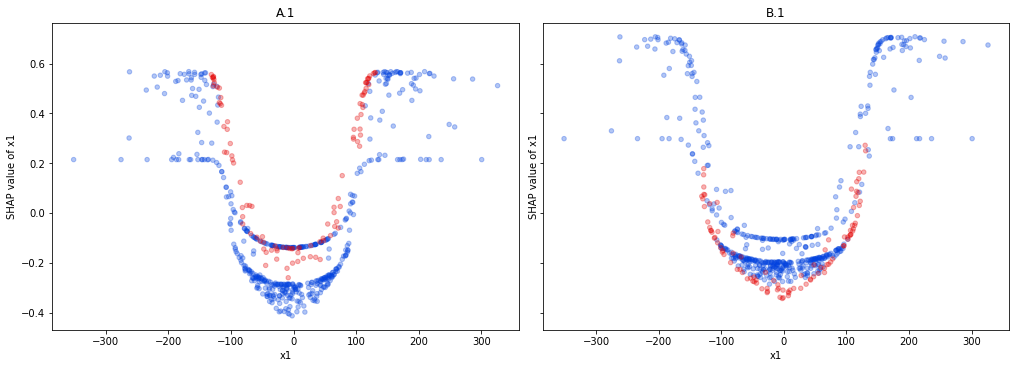

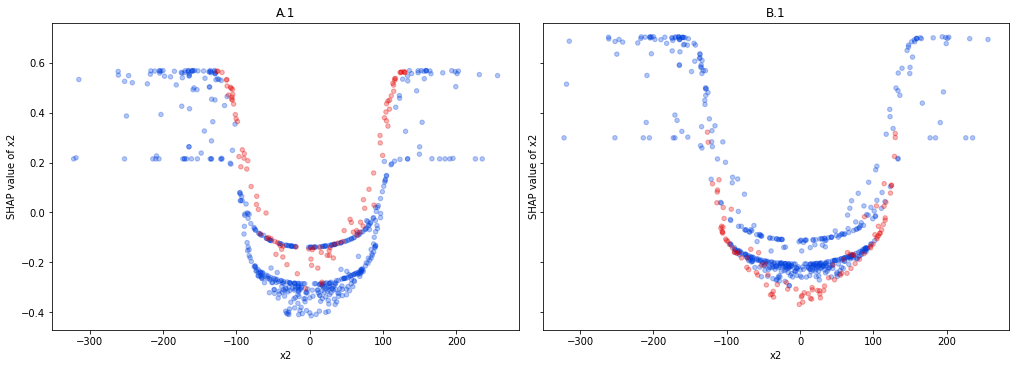

In [23]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Log Odds

In [24]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [25]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

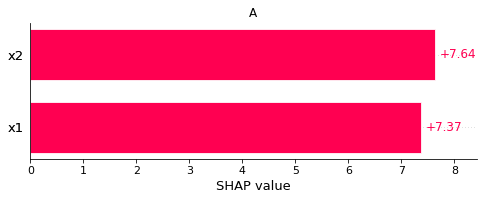

In [26]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

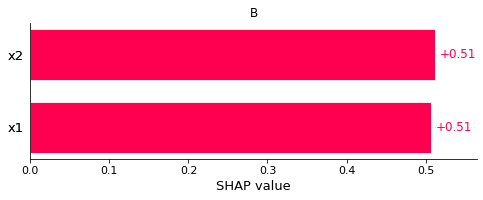

In [27]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

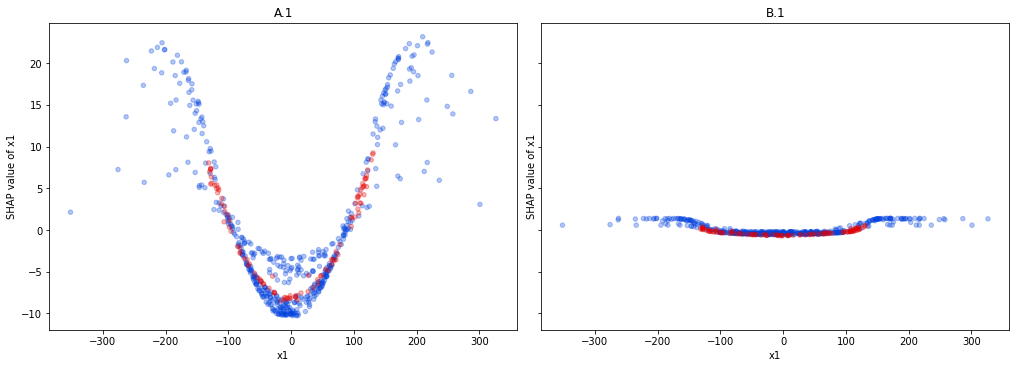

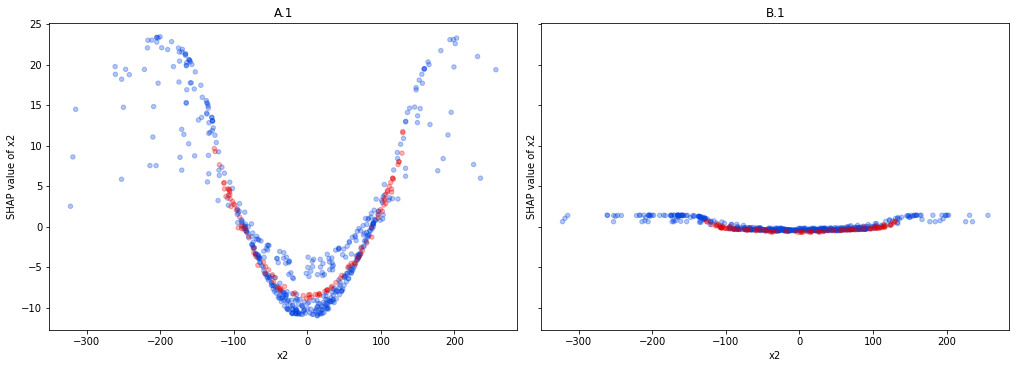

In [28]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

# Difference Classifier SHAP Explanations

## Labels

In [29]:
with open('explanations/diffclf.labels.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

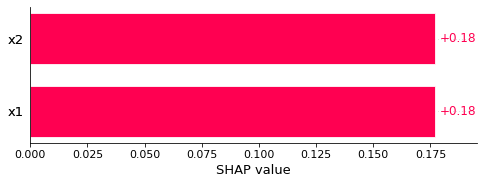

In [30]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

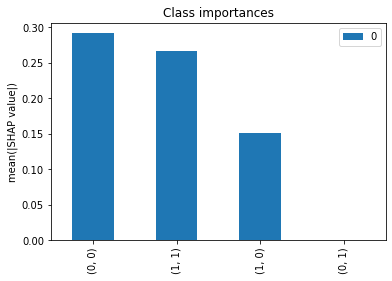

In [31]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

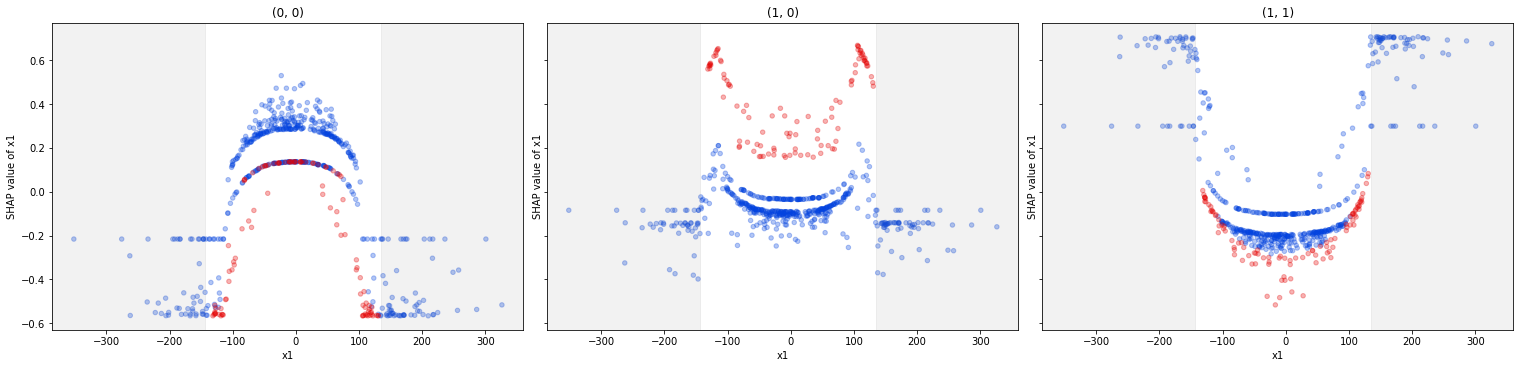

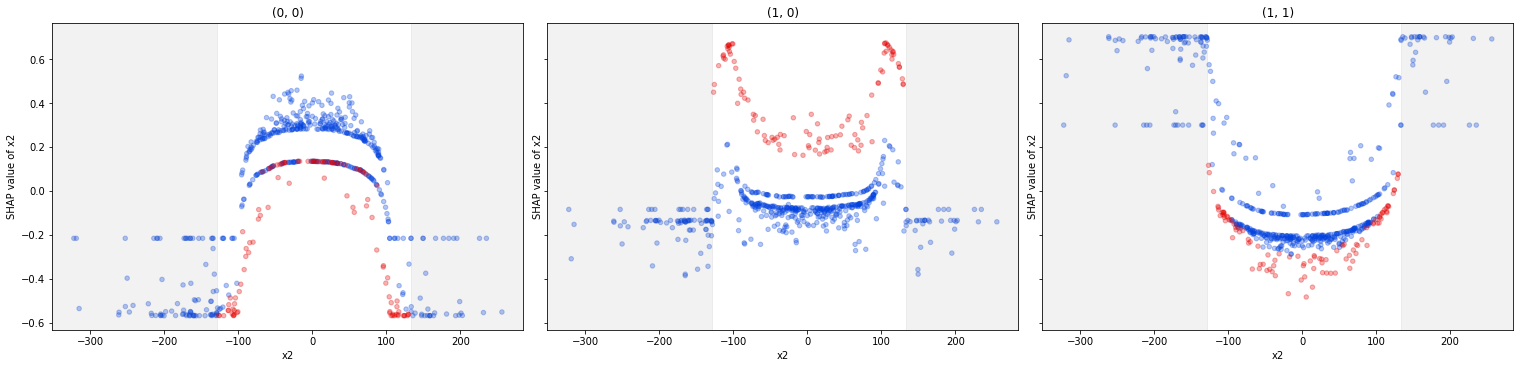

In [32]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Probability

In [33]:
with open('explanations/diffclf.proba.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

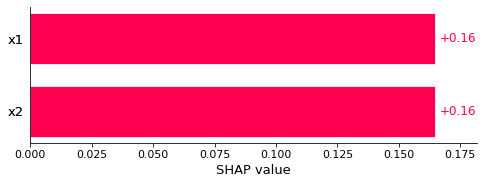

In [34]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

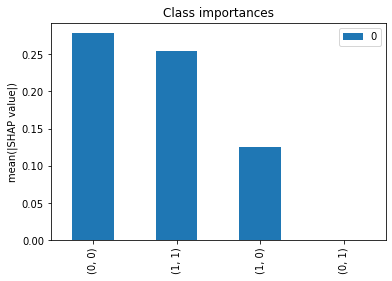

In [35]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

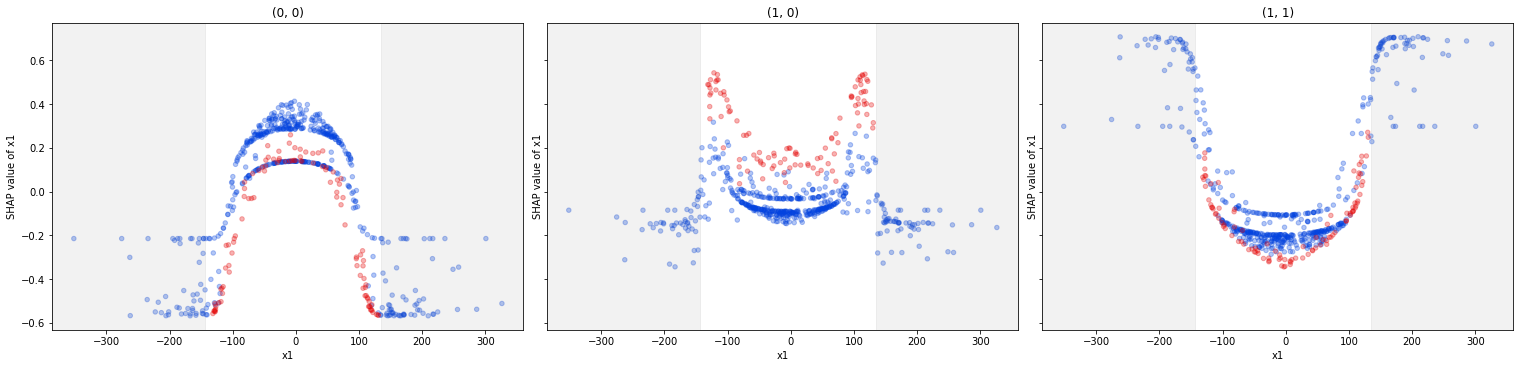

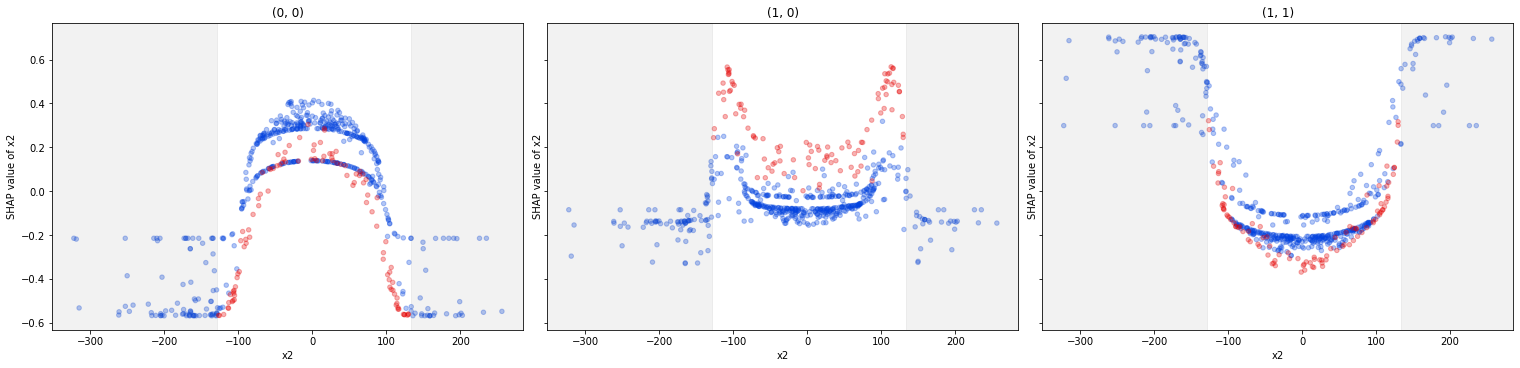

In [36]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Log Odds

In [37]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

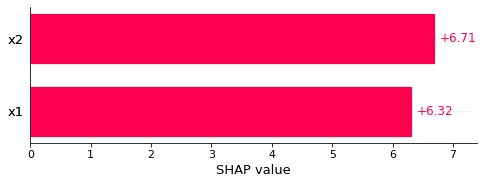

In [38]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

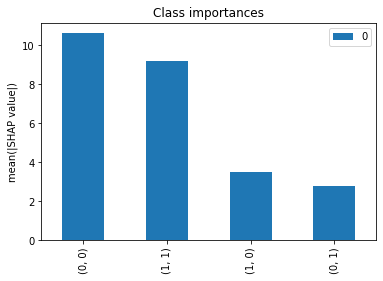

In [39]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

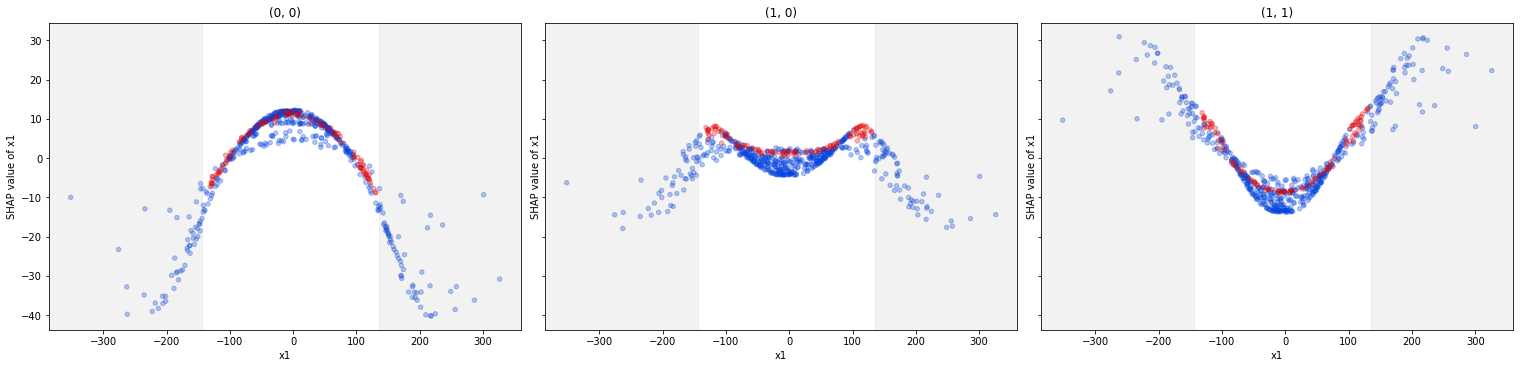

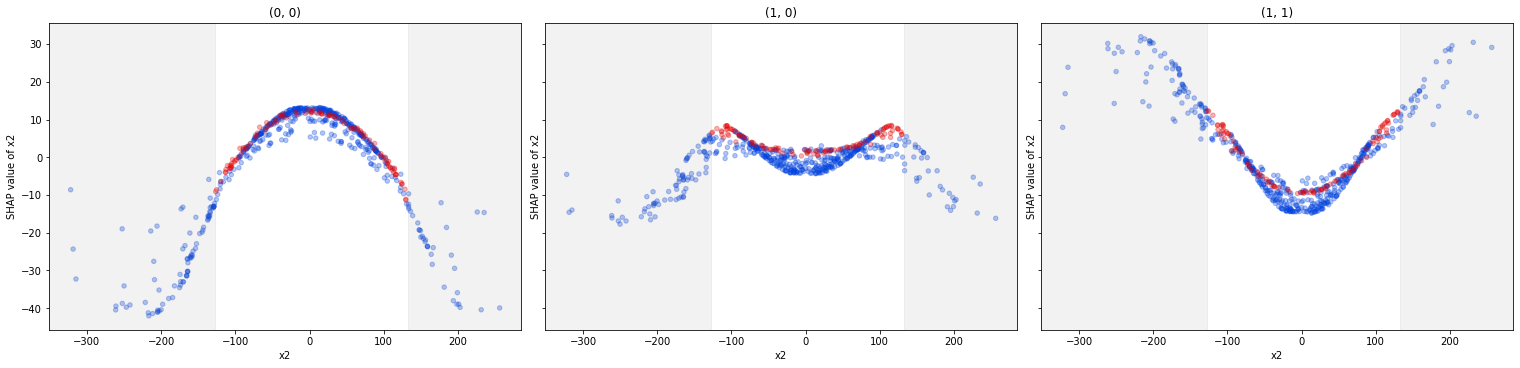

In [40]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)